# DDPG algorithm in flax

In [19]:
import gymnasium as gym
from collections import deque
import optax
import matplotlib.pyplot as plt
import numpy as np
import time
import random

import jax.tree_util as jtu
import jax.numpy as jnp
import jax

from flax.training import train_state, orbax_utils
from flax import linen as nn  # Linen API

from tqdm import tqdm
import orbax.checkpoint
import os
import shutil

F_CPP_MIN_LOG_LEVEL=0

In [20]:
ckpt_dir = './agent' # create the agent folder

## Usefull Methods

In [240]:
#random process N for action exploration 
class OUActionNoise:
    def __init__(self, key, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * jnp.sqrt(self.dt) * jax.random.normal(key, shape=self.mean.shape)
        )

        self.x_prev = x
        
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = jnp.zeros_like(self.mean)

In [22]:
# Define the method to update model parameters

# update critic
@jax.jit
def update_critic(model, states, actions, y):
    def compute_critic_loss(params):
        Q = model.apply_fn(params, states, actions)
        
        return jnp.mean((Q - y)**2) #compute loss
    
    loss, grads = jax.value_and_grad(compute_critic_loss)(model.params)
    updated_model = model.apply_gradients(grads=grads)
   
    return updated_model, loss

# udate actor
@jtu.Partial(jax.jit, static_argnums=(3,))
def update_actor(model, critic, states, action_dim):
    def compute_actor_loss(params):
        actions = model.apply_fn(params, states, action_dim)
        
        Q = critic.apply_fn(critic.params, states, actions)

        return -jnp.mean(Q)  # Compute the actor loss

    loss, grads = jax.value_and_grad(compute_actor_loss)(model.params)
    updated_model = model.apply_gradients(grads=grads)

    return updated_model, loss

# Define the soft update function
@jax.jit
def soft_update(target_params, source_params, tau):
    # Convert the source_params to a JAX-compatible data structure
    source_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), source_params)
    target_params_tree = jtu.tree_map(lambda x: jnp.asarray(x), target_params)

    # Compute the updated target parameters using a soft update
    updated_params = jtu.tree_map(lambda x, y: tau * x + (1 - tau) * y,
                                  source_params_tree, target_params_tree)

    return updated_params

## Define ReplayBuffer

In [135]:
# define the replay buffer
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer = deque(maxlen=self.buffer_size)
        self.buffer_counter = 0

    def add(self, transition):
        if len(self.buffer) >= self.buffer_size:
            self.buffer.pop(0)
            
        self.buffer.append(transition)
        
        self.buffer_counter += 1

    #TODO: finish to update fix the batching
    def sample_batch(self, key):
        record_range = min(self.buffer_counter, self.buffer_size)
        
        # if record_range < self.batch_size:
        #     print(len(self.buffer))
        #     raise ValueError("Replay buffer is too small to sample.")
            
        indices = jax.random.choice(
            key, 
            record_range,
            shape=(self.batch_size,), replace=True
        )
        
        batch = [self.buffer[i] for i in indices]
        
        return zip(*batch)        

## Define actor and critic model

In [24]:
#create the actor and critic newtorks like multilayer perceptrons
class Critic(nn.Module):
    """critic model MLP"""
    
    @nn.compact
    def __call__(self, observations, actions):
        x = jnp.concatenate([observations, actions], axis=-1)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return jnp.squeeze(x, axis=-1)
    
class Actor(nn.Module):
    """actor model MLP"""
    
    @nn.compact
    def __call__(self, x, action_dim):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=action_dim)(x)
        x = nn.tanh(x)
        return x

## Define algorithm parameters

In [307]:
#define key
seed = 0
random.seed(seed)
key = jax.random.PRNGKey(seed)

key, actor_key, critic_key = jax.random.split(key, 3)

In [308]:
# define environment and parameters
env = gym.make("InvertedPendulum-v4")
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]

#initialize parameters
episodes = 100
gamma = 0.99 #discount factor 0:nearly rewards, 1:future rewards
tau = 0.001 #polyak between 0-1 updating target network
max_episode_steps = 1000
buffer_size = int(1e6) #memory size
batch_size = 64 #The number of experiences sampled from the replay buffer
actor_learning_rate = 1e-3
critic_learning_rate = 1e-4
std_dev = 0.2  #scale of the noise for random process N for action exploration
noise = OUActionNoise(key, mean=jnp.zeros(1), std_deviation=float(std_dev) * jnp.ones(1))

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=max_episode_steps)

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)

## Initialize models and buffer

In [309]:
# Randomly initialize critic network Q(s, a|θ_Q ) and actor μ(s|θ_μ ) with weights θ_Q and θ_μ .
obs, _ = env.reset();

# Initialize the training state actor and critic models
critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=Critic().init(critic_key, obs, env.action_space.sample()), #init critic parameters
    tx=optax.adamw(learning_rate=critic_learning_rate, weight_decay=1e-2) #define optimizer
)

actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=Actor().init(actor_key, obs, action_dim), #init actor parameters
    tx=optax.adam(learning_rate=actor_learning_rate) #define optimizer
)

# to save agent
config = {'dimensions': jnp.array([5,3]), 'name': 'actor'}
ckpt = {'model': actor, 'config': config, 'data': actor.params}

# print(Actor().tabulate(key, obs, action_dim))
# print(Critic().tabulate(key, obs, env.action_space.sample()))

In [310]:
# Initialize target network Q_0_target and μ_0_target with weights 
# θ_Q_target ← θ_Q , θ_μ_target ← θ_μ

# Initialize the training state for flax porpuses
target_critic = train_state.TrainState.create(
    apply_fn=Critic().apply,
    params=critic.params,
    tx=optax.adamw(learning_rate=critic_learning_rate, weight_decay=1e-2)
)

target_actor = train_state.TrainState.create(
    apply_fn=Actor().apply,
    params=actor.params,
    tx=optax.adam(learning_rate=actor_learning_rate)
)

In [311]:
# Initialize replay buffer R
buffer = ReplayBuffer(buffer_size, batch_size)

## Training

In [312]:
episodes_reward = []
critic_loss = 0
actor_loss = 0

start_time = time.time()

for i in range(episodes):
    # Initialize a random process N for action exploration we do this in => noise()
    
    # Receive initial observation state s_1
    state, info = env.reset()
    done = False
    episode_len = 0
    
    while not done:
        
        # Select action a_t = μ(s t |θ μ ) + N t according to the current policy and exploration noise
        action = actor.apply_fn(actor.params, state, action_dim) + noise()
        
        # Execute action a t and observe reward r t and observe new state s t+1
        observation, reward, terminated, truncated, _ = env.step(action)
                
        # Store transition (s t , a t , r t , s t+1 ) in R
        transition = (state, action, reward, observation)
        buffer.add(transition)
                    
        # Sample a random minibatch of N transitions (s i , a i , r i , s i+1 ) from R
        # key, subkey = jax.random.split(key)
        states, actions, rewards, next_states = buffer.sample_batch(key)

        # Set y = r  + γQ^0 (s_{i+1} , μ^0 (s_{i+1} |θ^μ )|θ^Q ) P
        target_action = target_actor.apply_fn(target_actor.params,
                                              jnp.asarray(next_states),
                                              action_dim)


        target_q = target_critic.apply_fn(target_critic.params,
                                          jnp.asarray(next_states),
                                          jnp.asarray(target_action))

        rewards = jnp.asarray(rewards)

        # y = rewards + gamma * (1 - terminated) * target_q #corregir es un arreglo revisar paper
        y = rewards + gamma * target_q #corregir es un arreglo revisar paper


        # Update critic by minimizing the loss
        critic, critic_loss = update_critic(critic,
                                            jnp.asarray(states),
                                            jnp.asarray(actions),
                                            jnp.asarray(y))

        # Update the actor policy using the sampled gradient:
        actor, actor_loss = update_actor(actor,
                                         critic,
                                         jnp.asarray(states),
                                         action_dim)

        # Update the target networks:
        target_actor_params = soft_update(target_actor.params, actor.params, tau)
        target_critic_params = soft_update(target_critic.params, critic.params, tau)
        
        # update if the environment is done and the current observation
        done = terminated or truncated
        
        episode_len += 1
        state = observation


    episodes_reward.append(env.return_queue[-1]) 
    avg_reward = int(np.mean(env.return_queue))
    

    print("Episode:", i+1)
    
    print("Average reward =>", avg_reward,
          "Episode len =>", episode_len,
          "Critic loss =>", critic_loss, 
          "Actor loss =>", actor_loss, "\n") 

env.close()


# execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)

Episode: 1
Average reward => 32 Episode len => 32 Critic loss => 0.6322334 Actor loss => -1.0385733 

Episode: 2
Average reward => 20 Episode len => 8 Critic loss => 0.57368207 Actor loss => -1.4298896 

Episode: 3
Average reward => 23 Episode len => 31 Critic loss => 0.53784835 Actor loss => -2.2453227 

Episode: 4
Average reward => 19 Episode len => 5 Critic loss => 0.62696123 Actor loss => -2.3583531 

Episode: 5
Average reward => 16 Episode len => 5 Critic loss => 0.52092093 Actor loss => -2.2540622 

Episode: 6
Average reward => 14 Episode len => 5 Critic loss => 0.31177646 Actor loss => -2.2951317 

Episode: 7
Average reward => 12 Episode len => 4 Critic loss => 0.37063438 Actor loss => -2.2018507 

Episode: 8
Average reward => 11 Episode len => 4 Critic loss => 0.34382838 Actor loss => -2.1632857 

Episode: 9
Average reward => 10 Episode len => 4 Critic loss => 0.2662295 Actor loss => -2.2300713 

Episode: 10
Average reward => 10 Episode len => 4 Critic loss => 0.2323378 Actor l

## Save agent

In [43]:
# save agent
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('./agent', ckpt, save_args=save_args)

## Visualizing the training

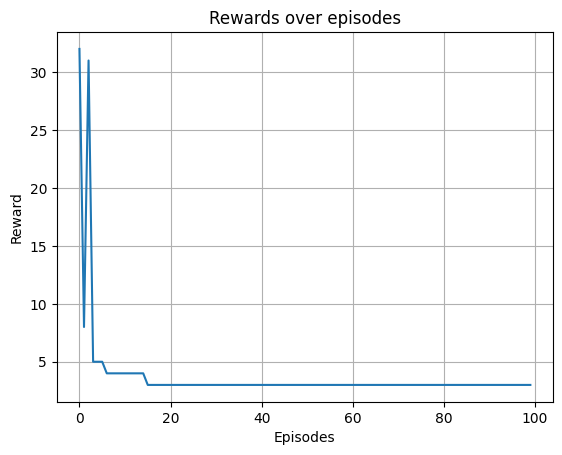

In [313]:
rewards_to_plot = [rewards for rewards in episodes_reward]

plt.plot(range(episodes), episodes_reward)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.grid()
plt.title('Rewards over episodes')
plt.show()

## Test Agent

In [ ]:
# restore agent
raw_restored = orbax_checkpointer.restore('./agent')
actor_params = raw_restored['data']

In [ ]:
env = gym.make("InvertedPendulum-v4", render_mode="human")

observation, info = env.reset()

for _ in range(1000):
    action = actor.apply_fn(actor_params, observation, env.action_space.shape[0])
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()